# SOM


In [100]:
import numpy as np

class Neuron:
    def __init__(self, x, y, length):
        self.x = x
        self.y = y
        self.length = length
        self.nf = 1000/10000000.
        self.w = [np.random.uniform(0,1) for i in range(self.length)]
        #print self.x, self.y, self.w
        
    def distance(self, example):
        return np.sqrt(np.sum((self.w-example)**2))        
        
    def gauss(self, win, it):
        r2 = (win.x-self.x)**2+(win.y-self.y)**2
        sigma = self.gain(it)
        A = 1/(2.0*np.pi*sigma**2)
        g = A*np.exp(-r2/(2.0*sigma**2))
        return g
    
    def gain(self, it):
        return np.exp(-it/self.nf)
    
    def learningRate(self, it):
        return 0.01*np.exp(-it/1000)
                       
    def update(self, example, win, it):      
        lr = self.learningRate(it)
        gg = self.gauss(win, it)
        
        dw = lr*gg*(example-self.w)
        self.w += dw
        return np.sum(dw**2)


In [102]:
class SOM:
    def __init__(self, dim, length):
        self.dim = dim
        self.length = length
        #self.neurons = [[Neuron(i,j, self.length) for j in range(self.dim)] for i in range(self.dim)]        
        self.neurons = []
        for i in range(self.dim):
            el = []
            for j in range(self.dim):
                neuron = Neuron(i, j, self.length)
                el.append(neuron)
            self.neurons.append(el)
    
    def debug(self):
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                print i, j, neuron.w
        
    def winner(self, example):
        retVal = self.neurons[0][0]
        _min = retVal.distance(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                d = neuron.distance(example)
                if d<_min:
                    _min = d
                    retVal = neuron
        return retVal
    
    def update(self, example, it):
        error = 0
        winner = self.winner(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                error += neuron.update(example, winner, it)
        return error/float(self.dim**2)
                        
    
    def fit(self, examples):
        maxerr = 0.001
        blok = 100
        for it in range(1000):
            err = 0
            n = 100
            for i in range(n):
                el = random.choice(examples)
                err += self.update(el, it)
            err = err/float(n)
            if err<maxerr:
                print '---- obucen -----'
                break
            print err


In [103]:
import random

_examples = [[0,0], [10,10], [0,10], [10,0]]
examples = []

for el in _examples:
    for r in range(20):
        da = random.uniform(-2, 2)
        db = random.uniform(-1, 1)
        examples.append([el[0]+da, el[1]+db])

examples = np.array(examples)

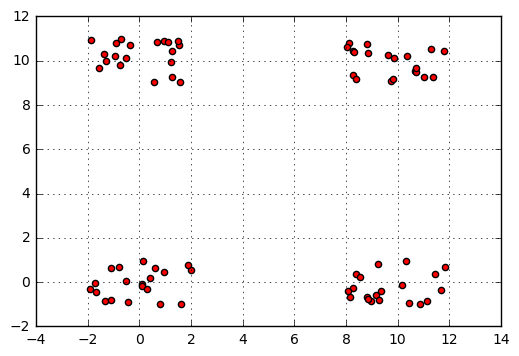

In [104]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(examples[:,0], examples[:,1], c='r')

plt.grid(True)


In [105]:
som = SOM(2, 2)

In [106]:
som.fit(examples)

---- obucen -----


In [107]:
som.debug()

0 0 [ 0.75004755  1.01543498]
0 1 [ 0.91555166  1.27941928]
1 0 [ 1.56996113  1.67970461]
1 1 [ 0.66013776  0.66544296]
